# Summary

This project is about analyzing the English Wikipedia traffic from January 1, 2008 through August 30, 2020. In particular, we will collect the data, perform the transformation, analyze the monthly traffic for various indicators, and visualize the final result in a comprehensive way.

A copy of the code, data, and documentation are available in a single GitHub repository:
https://github.com/liemluong/data-512/tree/main/data-512-a1

All the details are documented in this Jupyter notebook from the begginng to the end. The steps are executed in sequence.

------------------------------------------------------------------------------------------------------------------------

# STEP 1: GATHERING THE DATA

In this step, we will perform a series of steps to collect the data for our project from two API endpoints: 

**1. Legacy Pagecounts API**
   - This source provides access to desktop and mobile traffic data from December 2007 through July 2016
   
   
**2. Pageviews API**
   - This source provides access to desktop, mobile web, and mobile app traffic data from July 2015 through last month
   

There will be a total of five JSON source data file (one file per API query type). Each JSON filename will follow the naming convention to have a consistent format:
apiname_accesstype_firstmonth-lastmonth.json

---------------------------------------------------------------

The cell below displays a list of library from Python that we will need to import into this Jupyter notebook in order to execute the code and perform the analysis: json, csv, pandas, numpy, and matplotlib

In [1]:
import json
import requests
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

Set up the structure of the endpoints with componets in the correct order of the API format.

For simplicity, we will use "pagecounts" keyword to represent the legacy pagecount API and "pageviews" keyword to represent the pageview API 

In [2]:
endpoint_pagecounts = 'https://wikimedia.org/api/rest_v1/metrics/' \
                      'legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/' \
                     'pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

Each API data source has its data available for certain period and they are all within the January 2008 through August 2020. But if we use the same start and end for all five JSONs with Jan 2008 and Aug 2020 respectively, these will produce the very different chart from the assignment.

### Key factor in determine the correct start and end date
We have to take into the consideration of when the data is available based on the API documentation. By incorporating this factor with the assignment requirement, we will end up with the correct first 'start' and 'end' value for all JSON files. You will see the final visualization will be similar to the example from the assignment in the end.

Time series diagram below. 

**January 1, 2008 ------------------------------ July 2015-----------July 2016 ----------------------------- August 30, 2020**

**pagecount**
- Per API documentation, its data is available from December 2007 through **July 2016** == > **'end' is July 2016**
- Per the assignment analysis requirement from **Jan 2008** through August 2020 == > **'start' is Jan 2008**

**pageview**
- Per API documentation, its data is available from **July 2015** through last month == > **'start' is July 2015**
- Per the assignment analysis requirement from Jan 2008 through **August 2020** ==> **'end' is August 2020**

Now we need to set up the parameters for each API query that will fit into correct structure of previous endpoints. Below are the parameter values for five separate JSON queries

**Pagecount Desktop:** traffic parameters definition set up

In [3]:
# Note: 
# Per API documentation, its data is available from December 2007 through July 2016 == > 'end' is July 2016
# Per the assignment analysis requirement from Jan 2008 through August 2020 = > 'start' is Jan 2008

params_pagecounts_desktop_traffic = {"project" :     "en.wikipedia.org",
                                     "access-site" : "desktop-site",
                                     "granularity" : "monthly",
                                     "start" :       "2008010100",
                                     "end" :         "2016070100"
                                    }

**Pagecount Mobile:** traffic parameters definition set up

In [4]:
# Note: 
# Per API documentation, its data is available from December 2007 through July 2016 == > 'end' is July 2016
# Per the assignment analysis requirement from Jan 2008 through August 2020 = > 'start' is Jan 2008

params_pagecounts_mobile_traffic = {"project" :     "en.wikipedia.org",
                                    "access-site" : "mobile-site",
                                    "granularity" : "monthly",
                                    "start" :       "2008010100",
                                    "end" :         "2016070100"
                                   }

**Pageview Desktop:** traffic parameters definition set up

In [5]:
# Note:
# Per API documentation, its data is available from July 2015 through last month == > 'start' is July 2015
# Per the assignment analysis requirement from Jan 2008 through August 2020 ==> 'end' is August 2020
# Also the agent is set as user, this will ensure the query is from real user rather than web crawler

params_pageviews_desktop_traffic = {"project" :     "en.wikipedia.org",
                                    "access" :      "desktop",
                                    "agent" :       "user",
                                    "granularity" : "monthly",
                                    "start" :       "2015070100",
                                    "end" :         "2020080100"
                                    }

**Pageview Mobile:** web traffic parameters definition set up

In [6]:
# Note:
# Per API documentation, its data is available from July 2015 through last month == > 'start' is July 2015
# Per the assignment analysis requirement from Jan 2008 through August 2020 ==> 'end' is August 2020
# Also the agent is set as user, this will ensure the query is from real user rather than web crawler

params_pageviews_mobile_web_traffic = {"project" :     "en.wikipedia.org",
                                       "access" :      "mobile-web",
                                       "agent" :       "user",
                                       "granularity" : "monthly",
                                       "start" :       "2015070100",
                                       "end" :         "2020080100"
                                       }

**Pageview Mobile:** app traffic parameters definition set up

In [7]:
# Note: 
# Per API documentation, its data is available from July 2015 through last month == > 'start' is July 2015
# Per the assignment analysis requirement from Jan 2008 through August 2020 ==> 'end' is August 2020
# Also the agent is set as user, this will ensure the query is from real user rather than web crawler

params_pageviews_mobile_app_traffic = {"project" :     "en.wikipedia.org",
                                       "access" :      "mobile-app",
                                       "agent" :       "user",
                                       "granularity" : "monthly",
                                       "start" :       "2015070100",
                                       "end" :         "2020080100"
                                      }

When we execute the query to extract the data from the API, we dont want to be anonymous. Therefore, it is better to set up the header with your user information. This will help the API web server knowing this is a real and authentice users rather than some random robot.

In [8]:
# Below is my information for the header. You can customize these values with your own information

headers = {'User-Agent': 'https://github.com/liemluong',
           'From': 'liem99@uw.edu'
           }

After setting up the API queries and parameter values, now we need to define a function to execute the JSON files.
This is a one function using for all five JSON calls 

In [9]:
def api_call(endpoint, parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

The following cells will perform the steps:
1. Execution the API calls
2. Results from JSON query are saved to the approriate variables:
   - pagecounts_desktop
   - pagecounts_mobile
   - pageviews_desktop
   - pageviews_mobileweb
   - pageviews_mobileapp
3. Save the raw data from JSON file following the naming format: **apiname_accesstype_firstmonth-lastmonth.json**

Note: my five JSON files are saved into the same working directory of my Jupyer notebook. This location path will be different from your machine, so please feel free to change the directory path to meet your system.

**pagecounts_desktop:** call API and save JSON file

In [10]:
pagecounts_desktop = api_call(endpoint_pagecounts, params_pagecounts_desktop_traffic)

with open('pagecounts_desktop-site_200801_201607.json', 'w') as f:
    json.dump(pagecounts_desktop, f)

**pagecounts_mobile:** call API and save JSON file

In [11]:
pagecounts_mobile = api_call(endpoint_pagecounts, params_pagecounts_mobile_traffic)

with open('pagecounts_mobile-site_200801_201607.json', 'w') as f:
    json.dump(pagecounts_mobile, f)

**pageviews_desktop:** call API and save JSON file

In [12]:
pageviews_desktop = api_call(endpoint_pageviews, params_pageviews_desktop_traffic)

with open('pageviews_desktop_201507_202008.json', 'w') as f:
    json.dump(pageviews_desktop, f)

**pageview_mobileweb:** call API and save JSON file

In [13]:
pageviews_mobileweb = api_call(endpoint_pageviews, params_pageviews_mobile_web_traffic)

with open('pageviews_mobile-web_201507_202008.json', 'w') as f:
    json.dump(pageviews_mobileweb, f)

**pageview_mobileapp:** call API and save JSON file

In [14]:
pageviews_mobileapp = api_call(endpoint_pageviews, params_pageviews_mobile_app_traffic)

with open('pageviews_mobile-app_201507_202008.json', 'w') as f:
    json.dump(pageviews_mobileapp, f)

# STEP 2: PROCESSING THE DATA

In this step, we will perform a series of data transformations for these five json data results into a final structure that will be using for visualization in step 3

In details, below are the following tasks:
1. Read data from JSON files into data frame in Python
2. Keep only the relevant column fields for the analysis
3. For pageview data, we will combine mobile-app and mobile-web into one total mobile
4. For each pagecount and pageview, calculate the total view for both desktop and mobile in each category
5. Merge both final pagecount and pageview category into one final data frame
6. Splitting the year and month columns from the timestamp
7. For all months with 0 traffic data for any particular access method, the value for these columns will be converted to 0
8. Finally, save the final clean data into a CSV file with the name format: **en-wikipedia_traffic_200801-202008.csv**

For clean code, i denote 'pc' as pagecount and 'pv' as pageview for simplicity notation. Feel free to name its your choice. 

--------------------------------------------------------------------------------------------------------------------------

**Pagecount Desktop:** Reading the data from the JSON file into Python data frame structure

In [15]:
# open the first JSON file
f1 = open('pagecounts_desktop-site_200801_201607.json')

pc_desktop = json.load(f1)

f1.close()
# close the first JSON file

Format the data frame into a logical structure for analysis

In [16]:
# convert from dict to data frame
df_pc_desktop = pd.DataFrame.from_dict(pc_desktop['items']) 

# trim the columns from data frame to keep timestamp and count
df_pc_desktop = df_pc_desktop.drop(['project', 'access-site', 'granularity'], axis = 1)

# rename the columns in dataframe. using timestamp as a unique key for merging later
df_pc_desktop.columns = ['UniqueID', 'pagecount_desktop_views']

**Pagecount Mobile:** Reading the data from the JSON file into Python data frame structure

In [17]:
# open the second JSON file
f2 = open('pagecounts_mobile-site_200801_201607.json')

pc_mobile = json.load(f2)

f2.close()
# close the second JSON file

Format the data frame into a logical structure for analysis

In [18]:
# convert from dict to data frame
df_pc_mobile = pd.DataFrame.from_dict(pc_mobile['items']) 

# trim the columns from data frame to keep timestamp and count
df_pc_mobile = df_pc_mobile.drop(['project', 'access-site', 'granularity'], axis = 1)

# rename the columns in dataframe. using timestamp as a unique key for merging later
df_pc_mobile.columns = ['UniqueID', 'pagecount_mobile_views']

**Pageview Desktop:** Reading the data from the JSON file into Python data frame structure

In [19]:
# open the third JSON file
f3 = open('pageviews_desktop_201507_202008.json')

pv_desktop = json.load(f3)

f3.close()
# close the third JSON file

Format the data frame into a logical structure for analysis

In [20]:
# convert from dict to data frame
df_pv_desktop = pd.DataFrame.from_dict(pv_desktop['items']) 

# trim the columns from data frame to keep timestamp and count
df_pv_desktop = df_pv_desktop.drop(['project', 'access', 'agent', 'granularity'], axis = 1)

# rename the columns in dataframe. using timestamp as a unique key for merging later
df_pv_desktop.columns = ['UniqueID', 'pageview_desktop_views']

**Pageview Mobile Web:** Reading the data from the JSON file into Python data frame structure

In [21]:
# open the fourth JSON file
f4 = open('pageviews_mobile-web_201507_202008.json')

pv_mobile_web = json.load(f4)

f4.close()
# close the fourth JSON file

Format the data frame into a logical structure for analysis

In [22]:
# convert from dict to data frame
df_pv_mobile_web = pd.DataFrame.from_dict(pv_mobile_web['items']) 

# trim the columns from data frame to keep timestamp and count
df_pv_mobile_web = df_pv_mobile_web.drop(['project', 'access', 'agent', 'granularity'], axis = 1)

# rename the columns in dataframe. using timestamp as a unique key for merging later
df_pv_mobile_web.columns = ['UniqueID', 'pageview_mobile_web_views']

**Pageview Mobile App:** Reading the data from the JSON file into Python data frame structure

In [23]:
# open the fifth JSON file
f5 = open('pageviews_mobile-app_201507_202008.json')

pv_mobile_app = json.load(f5)

f5.close()
# close the fifth JSON file

Format the data frame into a logical structure for analysis

In [24]:
# convert from dict to data frame
df_pv_mobile_app = pd.DataFrame.from_dict(pv_mobile_app['items']) 

# trim the columns from data frame to keep timestamp and count
df_pv_mobile_app = df_pv_mobile_app.drop(['project', 'access', 'agent', 'granularity'], axis = 1)

# rename the columns in dataframe. using timestamp as a unique key for merging later
df_pv_mobile_app.columns = ['UniqueID', 'pageview_mobile_app_views']

After we have all five data frames in a good structure, we can merge them into the final format

**pagecount:**
  - df_pc_desktop
  - df_pc_mobile
  
== > we will merge these two data frame and then add the total views column for pagecount
  
  
**pageview:**  
  - df_pv_desktop
  - df_pv_mobile_web
  - df_pv_mobile_app
  
== > we will merge two mobile data frame into one total mobile and then we merge desktop and mobile into one data frame. Finally we addd the total views column for pageview


### MERGING Pagecount

Using pandas to merger with outer join between pc_desktop and pc_mobile

In [25]:
# using UniqueID (aka timestamp) as the primary key
df_pc_all = pd.merge(df_pc_desktop, df_pc_mobile, on = 'UniqueID', how = 'outer', indicator=True)

Reformat the values that are empty (NaN from the outer join) to be 0

In [26]:
# replace NaN with 0
df_pc_all['pagecount_desktop_views'] = df_pc_all['pagecount_desktop_views'].fillna(0)
df_pc_all['pagecount_mobile_views'] = df_pc_all['pagecount_mobile_views'].fillna(0)

Compute the total pagecount view and add it into the current data frame

In [27]:
# Add the column of total pagecount view
df_pc_all['pagecount_all_views'] = df_pc_all['pagecount_desktop_views'] + df_pc_all['pagecount_mobile_views']

Finally, we reorder the columns to have a logical order format for pagecount view. This will give us all information we need for pagecount.

In [28]:
# Reorder the columns of the data frame
df_pc_all = df_pc_all.reindex(columns = ['UniqueID', 
                                         'pagecount_all_views', 
                                         'pagecount_desktop_views', 
                                         'pagecount_mobile_views'])

### MERGING Pageview

Using pandas to merger with outer join between pv_mobileweb and pv_mobileapp

In [29]:
# using UniqueID (aka timestamp) as the primary key
df_pv_mobile = pd.merge(df_pv_mobile_web, df_pv_mobile_app, on = 'UniqueID', how = 'outer', indicator=True)

Compute the total pageview mobile view and add it into the current data frame.
Then we will remove these two mobile-web and mobile-app columns from the data frame.

In [30]:
# Add the column of total pageview mobile view
df_pv_mobile['pageview_mobile_views'] = df_pv_mobile['pageview_mobile_web_views'] + df_pv_mobile['pageview_mobile_app_views']

# trim the columns from data frame to keep timestamp and count
df_pv_mobile = df_pv_mobile.drop(['pageview_mobile_web_views', 
                                  'pageview_mobile_app_views', 
                                  '_merge'], axis = 1)

Now we will continue to merge the desktop view and mobile view of pageview. Using pandas to merger with outer join between them

In [31]:
# using UniqueID (aka timestamp) as the primary key
df_pv_all = pd.merge(df_pv_desktop, df_pv_mobile, on = 'UniqueID', how = 'outer', indicator=True)

Reformat the values that are empty (NaN from the outer join) to be 0

In [32]:
# replace NaN with 0
df_pv_all['pageview_desktop_views'] = df_pv_all['pageview_desktop_views'].fillna(0)
df_pv_all['pageview_mobile_views'] = df_pv_all['pageview_mobile_views'].fillna(0)

Compute the total pageview view and add it into the current data frame

In [33]:
# Add the column of total pageview all
df_pv_all['pageview_all_views'] = df_pv_all['pageview_desktop_views'] + df_pv_all['pageview_mobile_views']

Finally, we reorder the columns to have a logical order format for pageview view. This will give us all information we need for pageview. 

In [34]:
# Reorder the columns of the data frame
df_pv_all = df_pv_all.reindex(columns = ['UniqueID', 
                                         'pageview_all_views', 
                                         'pageview_desktop_views', 
                                         'pageview_mobile_views'])

### MERGING Pagecount and Pageview
Merge df_pc_all  and  df_pv_all into one final data frame with the outer join. This will provide the final results we want.

In [35]:
# using UniqueID (aka timestamp) as the primary key
df_final = pd.merge(df_pc_all, df_pv_all, on = 'UniqueID', how = 'outer', indicator=True)

With all the column data fields available in the final version of the data frame. We will need to do one more step to format NaN to 0 after the final merging process between df_pc_all and df_pv_all

In [36]:
# replace NaN with 0
df_final['pagecount_all_views'] = df_final['pagecount_all_views'].fillna(0)
df_final['pagecount_desktop_views'] = df_final['pagecount_desktop_views'].fillna(0)
df_final['pagecount_mobile_views'] = df_final['pagecount_mobile_views'].fillna(0)
df_final['pageview_all_views'] = df_final['pageview_all_views'].fillna(0)
df_final['pageview_desktop_views'] = df_final['pageview_desktop_views'].fillna(0)
df_final['pageview_mobile_views'] = df_final['pageview_mobile_views'].fillna(0)

After using the UniqueID as a primary key for merging, we dont need this UniqueID anymore going forward. We can now split it into two separate columns: year and month. Then we can drop it the UniqueID from the data frame

In [37]:
# Split the UniqueID (aka timestamp) into year and month columns
df_final['year'] = df_final['UniqueID'].str[:4]
df_final['month'] = df_final['UniqueID'].str[4:6]

# Clean up the dataframe (remove the unique key, and indicator column)
df_final = df_final.drop(['UniqueID', '_merge'], axis = 1)

The final data frame is almost there. We just need to reorder the columns to have a consistent look in a logical way for process thinking: Year, Month, then pagecount (all, desktop, mobile), and pageview (all, desktop, mobile)

In [38]:
# Reorder the columns of the data frame
df_final = df_final.reindex(columns = ['year',
                                       'month',
                                       'pagecount_all_views',
                                       'pagecount_desktop_views',
                                       'pagecount_mobile_views',
                                       'pageview_all_views', 
                                       'pageview_desktop_views', 
                                       'pageview_mobile_views'])

Now we have th final clean data structure that is exactly the format from the assignment requirement. We can now save this data into a CSV file.

Note: my CSV file is saved into the same working directory of my Jupyer notebook. This location path will be different from your machine, so please feel free to change the directory path to meet your system.

In [39]:
# Save final data frame to an csv file
df_final.to_csv (r'en-wikipedia_traffic_200801-202008.csv', index = False, header=True)

STEP 3: ANALYZE THE DATA
-----------------------------------------

In this step 3, we will finally create a chart visualization based on the final data CSV file we generate from previous step.

The visualization will track three traffic metrics:
- Mobile traffic
- Desktop traffic
- All traffic (desktop + mobile)

There are also customed format to show the distinction between pagecount (dash line) and pageview (solid line)

All the column fields from the final dataset are mapped on the same scale to ensure its correctness. Also, the chart will have the extra information for viewers: title, units, axis values, and legend

-----------------------------------------------------------------------------------------------------------------------------

We can use the final result from CSV file to plot the visualization. Let's loading the CSV into the Python 

In [40]:
# Loading the final data from CSV to make a visualization chart
data = pd.read_csv('en-wikipedia_traffic_200801-202008.csv')

Below are the series of step to plot the chart as well as the format to make it an insightful chart

Tasks that i performed:
1. Set up the time series structure serving as an index for generating continuous time series values

2. Remember from step 2 earlier, we format the value as 0 for the columnd where there are no view. When we generate the chart in step 3, these 0 values will display on the chart and make it a busy chart. We dont want to plot the 0 values because they are not significant. One way is to assign the 0 value as nan so that the plot will filter them out.

3. Plot the chart

4. Add additional components on the visualization: title, comment, legend, grid lines.

5. Enhancement for clean and elegant visual (data labels on x and y axis)
   - x axis: Instead of displaying every single year on the plot which makes it crowded, i display the years in interval of 2. As you can see, the visual is clean and elegant.
   
   - y axis: The number of traffic views is very big (10 digits value). Ex: Display the value like 5000000000 on the y axis is a terrible approach. One way we can display it like 5000K, 6000K, 7000K etc. The other way, we can shorten the value on the y axis and have the unit value (1e10) on top. I choose the later since it makes the chart cleaner in my view.

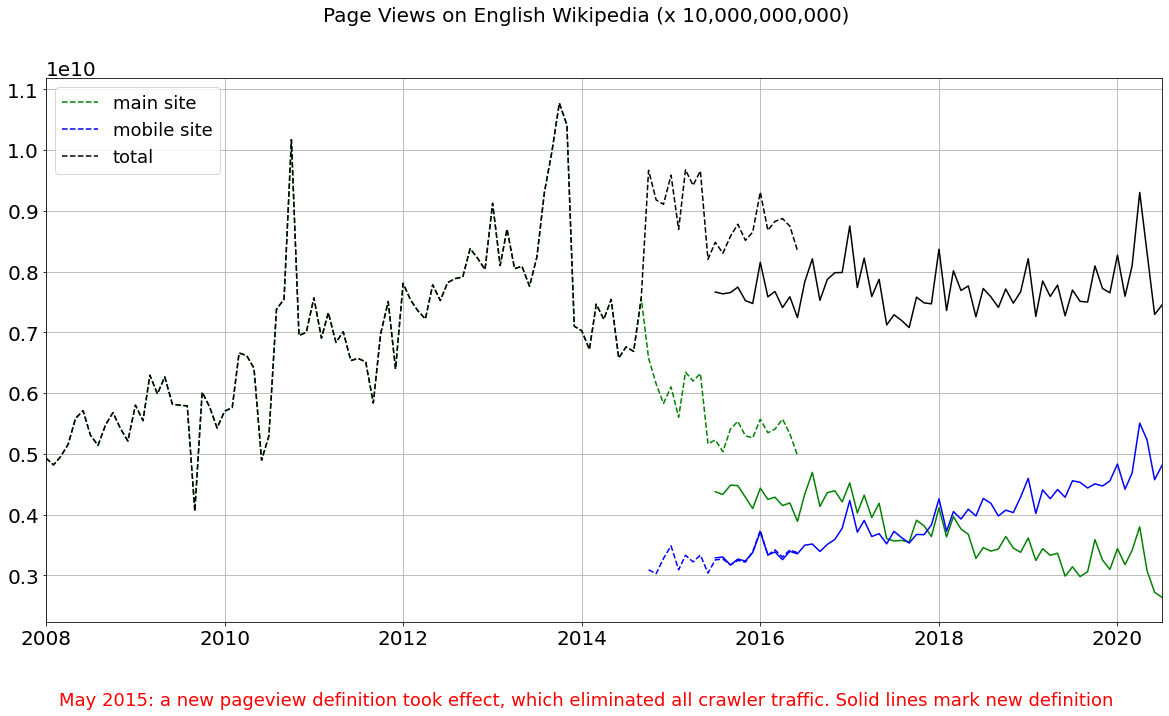

In [42]:
# Create a time series value to have the unique value serving as an index for our continous plot
time_series = data['month'].map(str) + '-' + data['year'].map(str)

# Format the time series as "month-year" for continuous data points
time_series = pd.to_datetime(time_series, format='%m-%Y')

# Set up the plot and its size
fig, ax = plt.subplots(figsize=(20, 10))

# Format the label on the x and y axis
plt.rc('ytick', labelsize=20) 
plt.rc('xtick', labelsize=20) 

# Pagecount Desktop View: Using numpy library to format the 0 values and then plot the chart
df2 = data.copy()
df2[df2.pagecount_desktop_views <= 0] = np.nan
plt.plot(time_series, df2.pagecount_desktop_views, linestyle='dashed', color='green', label='main site')

# Pagecount Mobile View: Using numpy library to format the 0 values and then plot the chart
df3 = data.copy()
df3[df3.pagecount_mobile_views <= 0] = np.nan
plt.plot(time_series, df3.pagecount_mobile_views, linestyle='dashed', color='blue', label='mobile site')

# Pagecount All View: Using numpy library to format the 0 values and then plot the chart
df1 = data.copy()
df1[df1.pagecount_all_views <= 0] = np.nan
plt.plot(time_series, df1.pagecount_all_views, linestyle='dashed', color='black', label='total' )

# Pageview All View: Using numpy library to format the 0 values and then plot the chart
df4 = data.copy()
df4[df4.pageview_all_views <= 0] = np.nan
plt.plot(time_series, df4.pageview_all_views, linestyle='solid', color='black')

# Pageview Desktop View: Using numpy library to format the 0 values and then plot the chart
df5 = data.copy()
df5[df5.pageview_desktop_views <= 0] = np.nan
plt.plot(time_series, df5.pageview_desktop_views, linestyle='solid', color='green')

# Pageview Mobile View: Using numpy library to format the 0 values and then plot the chart
df6 = data.copy()
df6[df6.pageview_mobile_views <= 0] = np.nan
plt.plot(time_series, df6.pageview_mobile_views, linestyle='solid', color='blue')

# Add the title to the chart
fig.suptitle('Page Views on English Wikipedia (x 10,000,000,000)', size=20) 

# Show the grid lines on the chart
plt.grid()

# Format the axis to start at the 0
plt.margins(x=0)

# Add the legend to the chart
plt.legend(loc= 'upper left', prop={'size':18}, bbox_to_anchor=(0,1))

# Add the comment at the bottom of the chart
txt="May 2015: a new pageview definition took effect, which eliminated all crawler traffic. Solid lines mark new definition"
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=18, color='red')

# Save the plot into a JPG picture file. The file will be saved in the same working directory of my Jupyter notebook.
# The path location will be different on your machine. Feel free to update the directory to your choice.
plt.savefig('A1_final_visualization.jpg', bbox_inches='tight', dpi=80)

plt.show();

**Final thoughts:**

By using JSON file with the correct **'start' and 'end'** values as i mentioned earlier, the final visualization is looking similar to the sample one from the assignment.

If you follow according to this Jupyter notebook, you will produce the same result like i did. 